# Hoax Detection Using Traditional Machine Learning
## Dataset from Satria Data 2020 - Big Data Challenge

This method represents words as dense word vectors which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions. **Word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus**

## Word Embedding Using Keras Embedding Layer

In [1]:
# import dependencies
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.backend import clear_session
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Flatten, GlobalMaxPooling1D
from pandarallel import pandarallel

%matplotlib inline

# multiprocessing Initialization
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Read Dataset
train_data = pd.read_excel("../data/training/DataLatih.xlsx", engine="openpyxl")
test_data = pd.read_excel("../data/testing/DataUji.xlsx", engine="openpyxl")

## Pre-processing

In [3]:
# Reconstruct train dataframe
train_df = pd.DataFrame()
train_df["konten"] = train_data["judul_translate"] + " " + train_data["narasi_translate"]
train_df["Class"] = train_data["label"]

# Reconstruct test dataframe
test_df = pd.DataFrame()
test_df["ID"] = test_data["ID"]
test_df["konten"] = test_data["judul_translate"] + " " + test_data["narasi_translate"]

In [4]:
# define stopword list, indonesia
STOPWORDS = set(StopWordRemoverFactory().get_stop_words() + stopwords.words('english'))

# define list kata singkat
KATASINGKAT = {"dlm":"dalam", "gw":"saya", "yg":"yang", "lu":"kamu", "dkt":"dekat", "kalo":"kalau", "n":"and"}

# define stemmer sastrawi for Indonesia
stemmer_ind = StemmerFactory().create_stemmer()
stemmer_eng = PorterStemmer()

In [5]:
# function of preprocessing
def remove_kata_singkat(word):
    if word in list(KATASINGKAT.keys()):
        return KATASINGKAT.get(word)
    else:
        return word
    
def normalize_word(row):
    # remove punctuation
    konten = re.sub(r'[^a-zA-Z\s]', ' ', row.konten, re.I|re.A)
    
    # case folding and remove kata singkat
    konten = " ".join([remove_kata_singkat(word.lower()).strip() for word in nltk.word_tokenize(konten)])
    
    # remove stopword and number
    konten = " ".join([word for word in nltk.word_tokenize(konten) if word not in punctuation and word.isalpha() and word not in STOPWORDS])
    
    # stemming
    konten = stemmer_ind.stem(konten)
    konten = stemmer_eng.stem(konten)
    
    # final assignment
    row.konten = konten
    
    return row

In [6]:
# Parallel preprocess to dataframe with progressbar
train_df = train_df.parallel_apply(normalize_word, axis=1)
test_df = test_df.parallel_apply(normalize_word, axis=1)

In [7]:
konten_train = train_df["konten"]
konten_test = test_df["konten"]

In [8]:
# konten_all = konten_train.append(konten_test)

In [9]:
konten_train.shape, konten_test.shape

((4231,), (470,))

In [10]:
# TOKENIZE BEFORE BUILD FEATURE
tokenizer = Tokenizer()
tokenizer.fit_on_texts(konten_train)

In [11]:
X = tokenizer.texts_to_sequences(konten_train)
y = train_df["Class"]
X_test = tokenizer.texts_to_sequences(konten_test)

In [12]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [13]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

## Build and Train Model

In [14]:
import keras
keras.backend.clear_session()

In [15]:
# hyperparameter
EPOCHS = 10
BS = 20
LEARNING_RATE = 0.001

In [16]:
# DEFINE MODEL
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           663100    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 663,361
Trainable params: 663,361
Non-trainable params: 0
_________________________________________________________________


In [17]:
# COMPILE MODEL
adam = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
# instantiate model callbacks
model_callbacks = [
        # EarlyStopping(monitor="val_loss", patience=5),
        CSVLogger(
            filename=f"../log/history_word_embedding.csv", separator=",", append=False),
        ModelCheckpoint(
            filepath=f"../model/model_word_embedding.h5", monitor="val_loss", save_best_only=True)
    ]

In [19]:
# TRAIN MODEL
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=EPOCHS, 
    batch_size=BS,
    callbacks=model_callbacks,
)

Epoch 1/10
170/170 [==============================] - 4s 16ms/step - loss: 0.6169 - accuracy: 0.8276 - val_loss: 0.4892 - val_accuracy: 0.8052
Epoch 2/10
170/170 [==============================] - 2s 12ms/step - loss: 0.4590 - accuracy: 0.8205 - val_loss: 0.4826 - val_accuracy: 0.8052
Epoch 3/10
170/170 [==============================] - 2s 12ms/step - loss: 0.4142 - accuracy: 0.8327 - val_loss: 0.4480 - val_accuracy: 0.8040
Epoch 4/10
170/170 [==============================] - 2s 12ms/step - loss: 0.3590 - accuracy: 0.8333 - val_loss: 0.4235 - val_accuracy: 0.8264
Epoch 5/10
170/170 [==============================] - 2s 12ms/step - loss: 0.2557 - accuracy: 0.8800 - val_loss: 0.4355 - val_accuracy: 0.8323
Epoch 6/10
170/170 [==============================] - 2s 12ms/step - loss: 0.1762 - accuracy: 0.9305 - val_loss: 0.4609 - val_accuracy: 0.8288
Epoch 7/10
170/170 [==============================] - 2s 12ms/step - loss: 0.1218 - accuracy: 0.9621 - val_loss: 0.4791 - val_accuracy: 0.8229

## Evaluate Model

In [20]:
# load saved model
model = load_model(f"../model/model_word_embedding.h5")

In [21]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy\t: {:.4f}".format(accuracy))
print("Training Loss\t\t: {:.4f}".format(loss))

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
print("\nValidation Accuracy\t: {:.4f}".format(val_accuracy))
print("Validation Loss\t\t: {:.4f}".format(val_loss))

Training Accuracy	: 0.8750
Training Loss		: 0.2697

Validation Accuracy	: 0.8264
Validation Loss		: 0.4235


In [22]:
y_pred = np.round(model.predict(X_val))

In [23]:
# [round(y[0]) for y in y_pred]
# print(y_pred)

In [24]:
# Classification Report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.18      0.28       165
           1       0.83      0.98      0.90       682

    accuracy                           0.83       847
   macro avg       0.78      0.58      0.59       847
weighted avg       0.81      0.83      0.78       847



<AxesSubplot:>

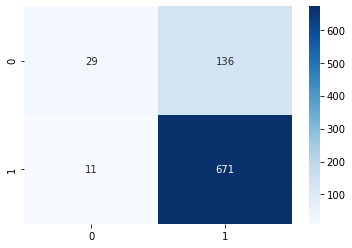

In [25]:
# Confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred, labels=[0,1])
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt='2')

## Visualization

In [26]:
# Font option
title_font = {'weight': 'medium', 'size': 'medium'}
axis_font = {'size': 'small'}

Numero = [x for x in range(EPOCHS)]

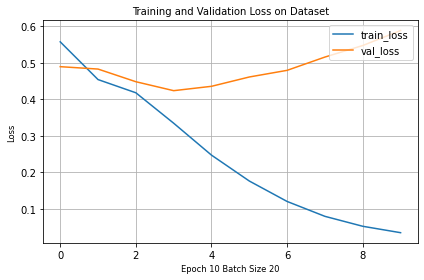

In [27]:
# Plot loss
plt.figure()
plt.plot(Numero, history.history["loss"], label="train_loss")
plt.plot(Numero, history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset", **title_font)
plt.xlabel(f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Loss", **axis_font)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()

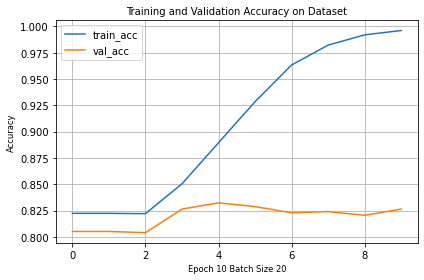

In [28]:
# plot accuracy
plt.figure()
plt.plot(Numero, history.history["accuracy"], label="train_acc")
plt.plot(Numero, history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on Dataset", **title_font)
plt.xlabel(
    f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Accuracy", **axis_font)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid()

## Save Results to CSV

In [29]:
predictions_word_embeddy = [int(y[0]) for y in np.round(model.predict(X_test))]
results_we = pd.DataFrame(zip(test_df["ID"], predictions_word_embeddy), columns=["ID", "Prediksi"])
results_we.to_csv("../result/neural_network/result_word_embedding.csv", index=False)

## Using Pretrained Word Embeddings

An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are [Word2Vec](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) developed by Google and [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) developed by the Stanford NLP Group.

### Reference
- https://realpython.com/python-keras-text-classification/
- https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work